# Parte 1: MLP tres arquitecturas con feature extractor

In [96]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import feature
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

saveImages = True

# Hiper parametros

dimensiones = 220
epochs = 23
batch = 130
std = 127
std_dev = 63
crop = 0
extractor = 'lbp'

In [97]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]

# Resized image directories
resized_covid_folder = 'dataset/resized_images/COVID'
resized_lung_opacity_folder = 'dataset/resized_images/Lung_Opacity'
resized_normal_folder = 'dataset/resized_images/Normal'
resized_viral_pneumonia_folder = 'dataset/resized_images/Viral_Pneumonia'
resized_folders = [resized_covid_folder, resized_lung_opacity_folder, resized_normal_folder, resized_viral_pneumonia_folder]

# Directories to save the standardized images
standardized_covid_folder = 'dataset/standardized_images/COVID'
standardized_lung_opacity_folder = 'dataset/standardized_images/Lung_Opacity'
standardized_normal_folder = 'dataset/standardized_images/Normal'
standardized_viral_pneumonia_folder = 'dataset/standardized_images/Viral_Pneumonia'
standardized_folders = [standardized_covid_folder, standardized_lung_opacity_folder, standardized_normal_folder, standardized_viral_pneumonia_folder]

# Directories to save the featured images
featured_covid_folder = 'dataset/featured_images/COVID'
featured_lung_opacity_folder = 'dataset/featured_images/Lung_Opacity'
featured_normal_folder = 'dataset/featured_images/Normal'
featured_viral_pneumonia_folder = 'dataset/featured_images/Viral_Pneumonia'
featured_folders = [featured_covid_folder, featured_lung_opacity_folder, featured_normal_folder, featured_viral_pneumonia_folder]


In [98]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        
# Convert to string time
def get_str_time(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    if hours == 0:
        if minutes == 0:
            return f'{seconds}s'
        return f'{minutes}m {seconds}s'
    return f'{hours}h {minutes}m {seconds}s'

# Calculate the metrics using sklearn.metrics
class_names = ['Covid', 'Lung Opacity', 'Normal', 'Pneumonia']
colors = ['blue', 'red', 'green', 'orange']
def get_metrics(model, X_test, y_test, time):

    # Get the model predictions
    y_pred  = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    # Get metrics
    report = classification_report(y_test, y_pred_classes, target_names=class_names)
    print(report)
    
    # Show charts
    ROC_auc(y_test, y_pred)
    
    # Show time
    print(f'Processing time: {time}\n')
    return report
    # accuracy = accuracy_score(y_test, y_pred_classes)
    # precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # Output
    # results = [accuracy, precision, recall, f1, time]
    
    # df = pd.DataFrame({
    # 'Metric': ['Accuracy', 'Recall', 'Precision', 'F1Score', 'Training time'],
    # 'Scores': results
    # }).style.hide().set_properties(**{'text-align': 'left'})

# Show ROC chart for each class
def ROC_auc(y_test, y_pred):
    # Compute the fpr (false positive rate), tpr (true positive rate), and thresholds for each class
    n_classes = y_test.max() + 1
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the ROC curves for each class
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='(AUC = %0.2f) %s' % (roc_auc[i], class_names[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# 1. DATA ANALYSIS

Image dimensions: (299, 299)


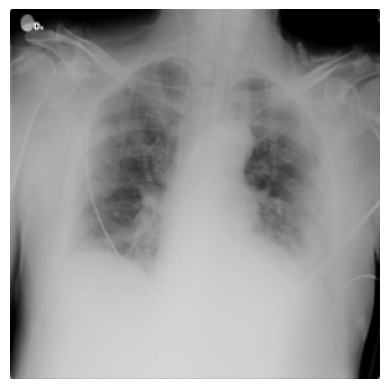

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [99]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 2. FEATURE ENGINEERING

Se toma una cantidad especifica de cada conjunto para que haya una similitud entre todos los conjuntos y se redimensionan a 128x128 

In [100]:
# Create directories if they don't exist
create_directories(resized_folders)

# Function to resize images and save them in the new directories
def resize_and_save_images(image_folder, resized_folder, samples):
    image_files = os.listdir(image_folder)
    image_files = image_files[:samples]  # Select the specified number of samples
    for file_name in image_files:
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Crop the image by 20 pixels on each side
        if(crop != 0):
            img = img[crop:-crop, crop:-crop]

        resized_img = cv2.resize(img, (200, 200))  # Resize the image
        new_file_name = os.path.splitext(file_name)[0] + '_resized.png'  # New file name
        cv2.imwrite(os.path.join(resized_folder, new_file_name), resized_img)

if saveImages:
    # Resize images and save images
    num_samples = [3616, 3700, 3700, 1345]
    [resize_and_save_images(clean_folder, resized_folder, samples) for clean_folder, resized_folder, samples in zip(clean_folders, resized_folders, num_samples)]
    print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")


STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.


Se estandarizan las imágenes después del redimensionamiento

Image dimensions: (200, 200)


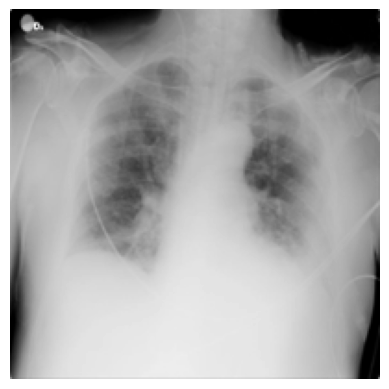

Number of images per class


In [101]:
# Show information
image = cv2.imread(resized_covid_folder+'/COVID-1_resized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=resized_folders, img=image)
# df

In [102]:
# Create directories if they don't exist
create_directories(standardized_folders)

# Function to standardize and save images to new directories
def standardize_and_save_images(resized_folder, standardized_folder):
    for filename in os.listdir(resized_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(resized_folder, filename)  # Path to the current image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
            image_float = image.astype("float32")  # Convert the image to a float32 NumPy array
            mean, std_dev = cv2.meanStdDev(image_float)  # Calculate mean and standard deviation
            standardized_mean = std
            standardized_std_dev = std_dev
            standardized_image = (image_float - mean) / std_dev * standardized_std_dev + standardized_mean
            standardized_image_uint8 = standardized_image.astype("uint8")  # Convert image to uint8
            new_filename = os.path.splitext(filename)[0] + '_standardized.png'  # New file name
            cv2.imwrite(os.path.join(standardized_folder, new_filename), standardized_image_uint8)  # Save the standardized image

if saveImages:
    # Standardize and save images
    [standardize_and_save_images(resized_folder, standardized_folder) for resized_folder, standardized_folder in zip(resized_folders, standardized_folders)]
    print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")

STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (200, 200)


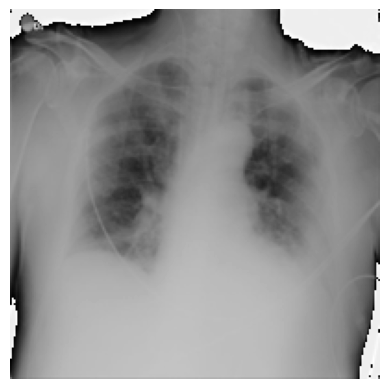

Number of images per class


In [103]:
# Show information
image = cv2.imread(standardized_covid_folder+'/COVID-1_resized_standardized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=standardized_folders, img=image)
# df

# 3. FEATURE EXTRACTOR

In [104]:
# Create directories if they don't exist
create_directories(featured_folders)

# Aplica el extractor de Histogramas de Color
def color_histograms(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    n = sum(hist.flatten())
    hist_normalized = hist.flatten() / n
    return hist_normalized

# Aplica Local Binary Patterns
radius = 1 # Radius of the circle used to calculate the patterns
points = 8 * radius # Number of sampling points on the circle
def local_binary_patterns(image):
    lbp = feature.local_binary_pattern(image, points, radius, method='uniform')
    # lbp_normalized = np.uint8((lbp / np.max(lbp)) * 255)
    lbp_normalized = cv2.normalize(lbp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return lbp_normalized

# Function to standardize and save images to new directories
def apply_feature_extractor(standardized_folder, featured_folder, filter):
    for filename in os.listdir(standardized_folder):
        image_path = os.path.join(standardized_folder, filename)   # Path to the current image        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
        
        # Applies the corresponding extractor according to the type of filter
        if   filter.lower() == "histo" : featured_image = color_histograms(image)
        elif filter.lower() == "lbp"   : featured_image = local_binary_patterns(image)
        else:
            print("Tipo de filtro no válido. Debe ser 'Histo' o 'LBP'.")
            continue
    
        # Save the result as an image in the output directory
        new_filename = os.path.splitext(filename)[0].replace("_resized_standardized", "") + '_featured.png'  # New file name
        cv2.imwrite(os.path.join(featured_folder, new_filename), featured_image) # Save the image

if saveImages:
    # Standardize and save images
    feature_extractor = extractor
    [apply_feature_extractor(standardized_folder, featured_folder, filter=feature_extractor) for standardized_folder, featured_folder in zip(standardized_folders, featured_folders)]
    print("FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.")

FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (200, 200)


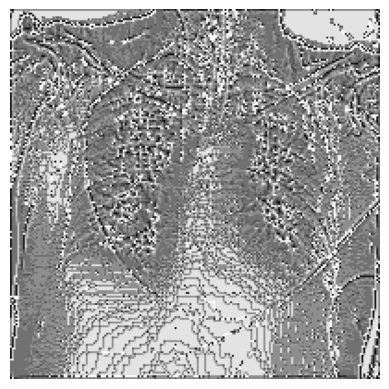

Number of images per class


In [105]:
# Show information
image = cv2.imread(featured_covid_folder+'/COVID-1_featured.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=featured_folders, img=image)
# df

# 4. TRAINING

Load the data of 'X' and 'y'

In [106]:
# Load lung images
# covid_data = load_data(standardized_covid_folder, 0)
# lung_opacity_data = load_data(standardized_lung_opacity_folder, 1)
# normal_data = load_data(standardized_normal_folder, 2)
# viral_pneumonia_data = load_data(standardized_viral_pneumonia_folder, 3)

covid_data = load_data(featured_covid_folder, 0)
lung_opacity_data = load_data(featured_lung_opacity_folder, 1)
normal_data = load_data(featured_normal_folder, 2)
viral_pneumonia_data = load_data(featured_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [107]:
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocess the data
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Check the dimensions of the training and test sets
pd.DataFrame({
    'Variable': ['X train', 'y train',  'X test', 'y test'],
    'Dimensions': [X_train.shape, y_train_categorical.shape, X_test.shape, y_test_categorical.shape],
}).style.hide().set_properties(**{'text-align': 'left'})


Variable,Dimensions
X train,"(8652, 200, 200)"
y train,"(8652, 4)"
X test,"(3709, 200, 200)"
y test,"(3709, 4)"


# MLP

## Arquitectura 1

In [108]:
# Create the MLP model
model1 = Sequential()
model1.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))

# Compile model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()
model1.fit(X_train, y_train_categorical, batch_size=batch, epochs=epochs, verbose=2)
train_time = get_str_time(time.time() - start)

Epoch 1/23
67/67 - 1s - loss: 1657.6010 - accuracy: 0.2809 - 1s/epoch - 19ms/step
Epoch 2/23
67/67 - 1s - loss: 255.5683 - accuracy: 0.3924 - 1s/epoch - 17ms/step
Epoch 3/23
67/67 - 1s - loss: 200.1172 - accuracy: 0.4016 - 1s/epoch - 17ms/step
Epoch 4/23
67/67 - 1s - loss: 122.8520 - accuracy: 0.5079 - 1s/epoch - 17ms/step
Epoch 5/23
67/67 - 1s - loss: 63.4549 - accuracy: 0.5199 - 1s/epoch - 17ms/step
Epoch 6/23
67/67 - 1s - loss: 52.9336 - accuracy: 0.5548 - 1s/epoch - 17ms/step
Epoch 7/23
67/67 - 1s - loss: 95.1338 - accuracy: 0.4768 - 1s/epoch - 17ms/step
Epoch 8/23
67/67 - 1s - loss: 86.6615 - accuracy: 0.4668 - 1s/epoch - 16ms/step
Epoch 9/23
67/67 - 1s - loss: 21.3311 - accuracy: 0.5848 - 1s/epoch - 17ms/step
Epoch 10/23
67/67 - 1s - loss: 16.3351 - accuracy: 0.6543 - 1s/epoch - 17ms/step
Epoch 11/23
67/67 - 1s - loss: 13.0373 - accuracy: 0.7197 - 1s/epoch - 17ms/step
Epoch 12/23
67/67 - 1s - loss: 3.9801 - accuracy: 0.8158 - 1s/epoch - 17ms/step
Epoch 13/23
67/67 - 1s - loss: 6.

116/116 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       Covid       0.74      0.79      0.76      1085
Lung Opacity       0.75      0.69      0.72      1110
      Normal       0.67      0.67      0.67      1110
   Pneumonia       0.77      0.77      0.77       404

    accuracy                           0.72      3709
   macro avg       0.73      0.73      0.73      3709
weighted avg       0.72      0.72      0.72      3709



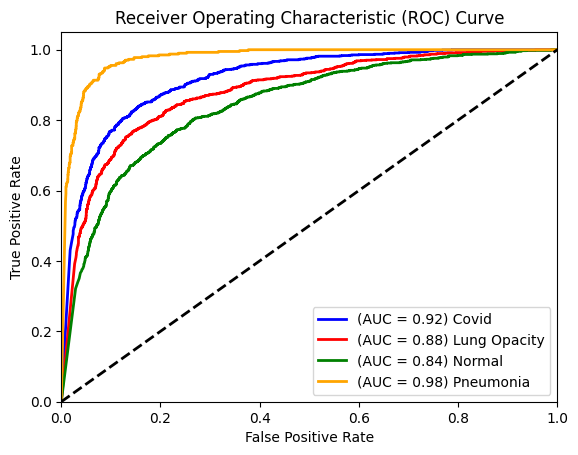

Processing time: 26s



In [109]:
# Evaluate model    
results1 = get_metrics(model=model1, X_test=X_test, y_test=y_test, time=train_time)

## Arquitectura 2

In [110]:
# Create the MLP model
model2 = Sequential()
model2.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='elu'))
model2.add(Dense(4, activation='softmax'))

# Compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
start = time.time()
model2.fit(X_train, y_train_categorical, batch_size=batch, epochs=epochs, verbose=2)
train_time = get_str_time(time.time() - start)

Epoch 1/23
67/67 - 1s - loss: 1422.0641 - accuracy: 0.3027 - 1s/epoch - 20ms/step
Epoch 2/23
67/67 - 1s - loss: 359.2624 - accuracy: 0.3222 - 1s/epoch - 18ms/step
Epoch 3/23
67/67 - 1s - loss: 246.3365 - accuracy: 0.3470 - 1s/epoch - 17ms/step
Epoch 4/23
67/67 - 1s - loss: 45.6566 - accuracy: 0.4813 - 1s/epoch - 17ms/step
Epoch 5/23
67/67 - 1s - loss: 19.1772 - accuracy: 0.5459 - 1s/epoch - 17ms/step
Epoch 6/23
67/67 - 1s - loss: 22.2823 - accuracy: 0.5445 - 1s/epoch - 17ms/step
Epoch 7/23
67/67 - 1s - loss: 71.4603 - accuracy: 0.4600 - 1s/epoch - 17ms/step
Epoch 8/23
67/67 - 1s - loss: 44.6552 - accuracy: 0.3985 - 1s/epoch - 17ms/step
Epoch 9/23
67/67 - 1s - loss: 22.9551 - accuracy: 0.5023 - 1s/epoch - 17ms/step
Epoch 10/23
67/67 - 1s - loss: 4.4170 - accuracy: 0.6871 - 1s/epoch - 17ms/step
Epoch 11/23
67/67 - 1s - loss: 3.2808 - accuracy: 0.6943 - 1s/epoch - 17ms/step
Epoch 12/23
67/67 - 1s - loss: 2.1041 - accuracy: 0.7434 - 1s/epoch - 17ms/step
Epoch 13/23
67/67 - 1s - loss: 1.371

116/116 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00      1085
Lung Opacity       0.30      1.00      0.46      1110
      Normal       0.00      0.00      0.00      1110
   Pneumonia       0.00      0.00      0.00       404

    accuracy                           0.30      3709
   macro avg       0.07      0.25      0.12      3709
weighted avg       0.09      0.30      0.14      3709



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


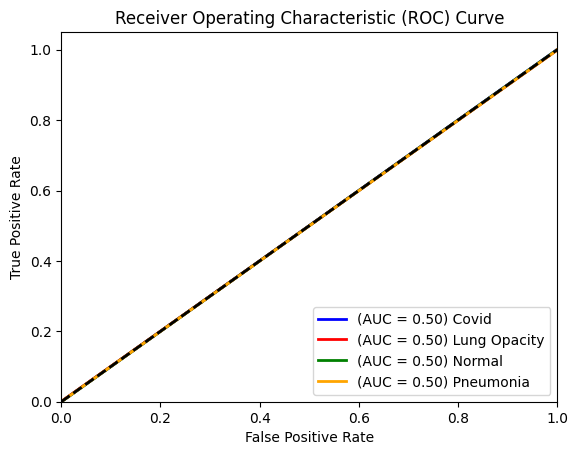

Processing time: 7s



In [117]:
# Evaluate model    
results2 = get_metrics(model=model2, X_test=X_test, y_test=y_test, time=train_time)

## Arquitectura 3

In [112]:
# Create the MLP model
model3 = Sequential()
model3.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(4, activation='softmax'))

# Compile model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
start = time.time()
model3.fit(X_train, y_train_categorical, batch_size=batch, epochs=15, verbose=2)
train_time = get_str_time(time.time() - start)

Epoch 1/15
67/67 - 1s - loss: 553.4142 - accuracy: 0.2915 - 715ms/epoch - 11ms/step
Epoch 2/15
67/67 - 1s - loss: 271.0449 - accuracy: 0.3219 - 518ms/epoch - 8ms/step
Epoch 3/15
67/67 - 1s - loss: 41.5195 - accuracy: 0.4170 - 510ms/epoch - 8ms/step
Epoch 4/15
67/67 - 1s - loss: 22.1530 - accuracy: 0.4947 - 502ms/epoch - 7ms/step
Epoch 5/15
67/67 - 0s - loss: 54.1200 - accuracy: 0.4255 - 487ms/epoch - 7ms/step
Epoch 6/15
67/67 - 0s - loss: 12.2037 - accuracy: 0.5809 - 492ms/epoch - 7ms/step
Epoch 7/15
67/67 - 1s - loss: 12.6990 - accuracy: 0.5791 - 511ms/epoch - 8ms/step
Epoch 8/15
67/67 - 1s - loss: 6.7688 - accuracy: 0.6430 - 504ms/epoch - 8ms/step
Epoch 9/15
67/67 - 0s - loss: 12.8338 - accuracy: 0.5831 - 492ms/epoch - 7ms/step
Epoch 10/15
67/67 - 0s - loss: 2.6015 - accuracy: 0.7758 - 491ms/epoch - 7ms/step
Epoch 11/15
67/67 - 0s - loss: 16.1681 - accuracy: 0.5043 - 492ms/epoch - 7ms/step
Epoch 12/15
67/67 - 0s - loss: 9.3268 - accuracy: 0.6016 - 496ms/epoch - 7ms/step
Epoch 13/15
6

116/116 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       Covid       0.76      0.65      0.70      1085
Lung Opacity       0.76      0.58      0.66      1110
      Normal       0.52      0.76      0.62      1110
   Pneumonia       0.80      0.64      0.71       404

    accuracy                           0.66      3709
   macro avg       0.71      0.66      0.67      3709
weighted avg       0.69      0.66      0.66      3709



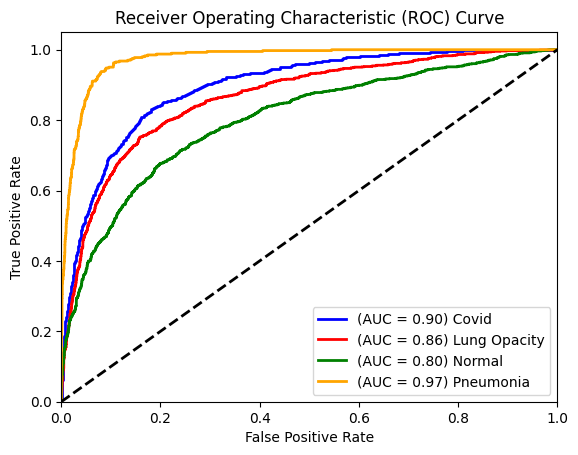

Processing time: 7s



In [120]:
# # Evaluate model
results3 = get_metrics(model=model3, X_test=X_test, y_test=y_test, time=train_time)

# Resultados

In [124]:
# pd.DataFrame({
#     'Metric': ['Accuracy', 'Recall', 'Precision', 'Training time'],
#     'Arch 1': results1,
#     'Arch 2': results2,
#     'Arch 3': results3,
# }).style.hide().set_properties(**{'text-align': 'left'})

print("Arquitectura 1:")
print(results1)
print("Arquitectura 2:")
print(results2)
print("Arquitectura 3:")
print(results3)

Arquitectura 1:
              precision    recall  f1-score   support

       Covid       0.74      0.79      0.76      1085
Lung Opacity       0.75      0.69      0.72      1110
      Normal       0.67      0.67      0.67      1110
   Pneumonia       0.77      0.77      0.77       404

    accuracy                           0.72      3709
   macro avg       0.73      0.73      0.73      3709
weighted avg       0.72      0.72      0.72      3709

Arquitectura 2:
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00      1085
Lung Opacity       0.30      1.00      0.46      1110
      Normal       0.00      0.00      0.00      1110
   Pneumonia       0.00      0.00      0.00       404

    accuracy                           0.30      3709
   macro avg       0.07      0.25      0.12      3709
weighted avg       0.09      0.30      0.14      3709

Arquitectura 3:
              precision    recall  f1-score   support

       Covid       0.76    

# Mejor resultado obtenido:

## Arquitectura 1:

In [125]:
print("Arquitectura 1:")
print(results1)

Arquitectura 1:
              precision    recall  f1-score   support

       Covid       0.74      0.79      0.76      1085
Lung Opacity       0.75      0.69      0.72      1110
      Normal       0.67      0.67      0.67      1110
   Pneumonia       0.77      0.77      0.77       404

    accuracy                           0.72      3709
   macro avg       0.73      0.73      0.73      3709
weighted avg       0.72      0.72      0.72      3709



In [131]:
model1.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 40000)             0         
                                                                 
 dense_139 (Dense)           (None, 128)               5120128   
                                                                 
 dense_140 (Dense)           (None, 128)               16512     
                                                                 
 dense_141 (Dense)           (None, 4)                 516       
                                                                 
Total params: 5137156 (19.60 MB)
Trainable params: 5137156 (19.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Comparación: MLP con Feature extractor vs mejor resultado de MLP sin feature extractor

In [127]:
print("Arquitectura 1 con feature extractor:")
print(results1)

print("Arquitectura 1 sin feature extractor:")
print("              precision    recall  f1-score   support")
print("")
print("       Covid       0.71      0.59      0.64      1085")
print("Lung Opacity       0.77      0.55      0.64      1110")
print("      Normal       0.65      0.78      0.71      1110")
print("   Pneumonia       0.57      0.96      0.71       404")
print("")
print("    accuracy                           0.67      3709")
print("   macro avg       0.67      0.72      0.68      3709")
print("weighted avg       0.69      0.67      0.67      3709")

Arquitectura 1 con feature extractor:
              precision    recall  f1-score   support

       Covid       0.74      0.79      0.76      1085
Lung Opacity       0.75      0.69      0.72      1110
      Normal       0.67      0.67      0.67      1110
   Pneumonia       0.77      0.77      0.77       404

    accuracy                           0.72      3709
   macro avg       0.73      0.73      0.73      3709
weighted avg       0.72      0.72      0.72      3709

Arquitectura 1 sin feature extractor:
              precision    recall  f1-score   support

       Covid       0.71      0.59      0.64      1085
Lung Opacity       0.77      0.55      0.64      1110
      Normal       0.65      0.78      0.71      1110
   Pneumonia       0.57      0.96      0.71       404

    accuracy                           0.67      3709
   macro avg       0.67      0.72      0.68      3709
weighted avg       0.69      0.67      0.67      3709


## ROC y AUC CON feature extractor:

116/116 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       Covid       0.74      0.79      0.76      1085
Lung Opacity       0.75      0.69      0.72      1110
      Normal       0.67      0.67      0.67      1110
   Pneumonia       0.77      0.77      0.77       404

    accuracy                           0.72      3709
   macro avg       0.73      0.73      0.73      3709
weighted avg       0.72      0.72      0.72      3709



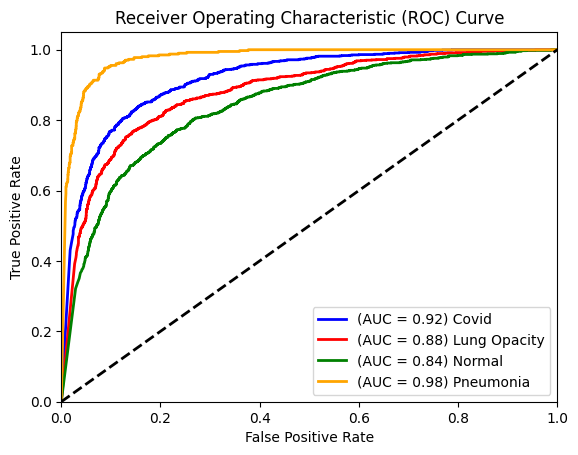

Processing time: 7s



In [128]:
# Evaluate model    
results1 = get_metrics(model=model1, X_test=X_test, y_test=y_test, time=train_time)

## ROC y AUC SIN feature extractor:

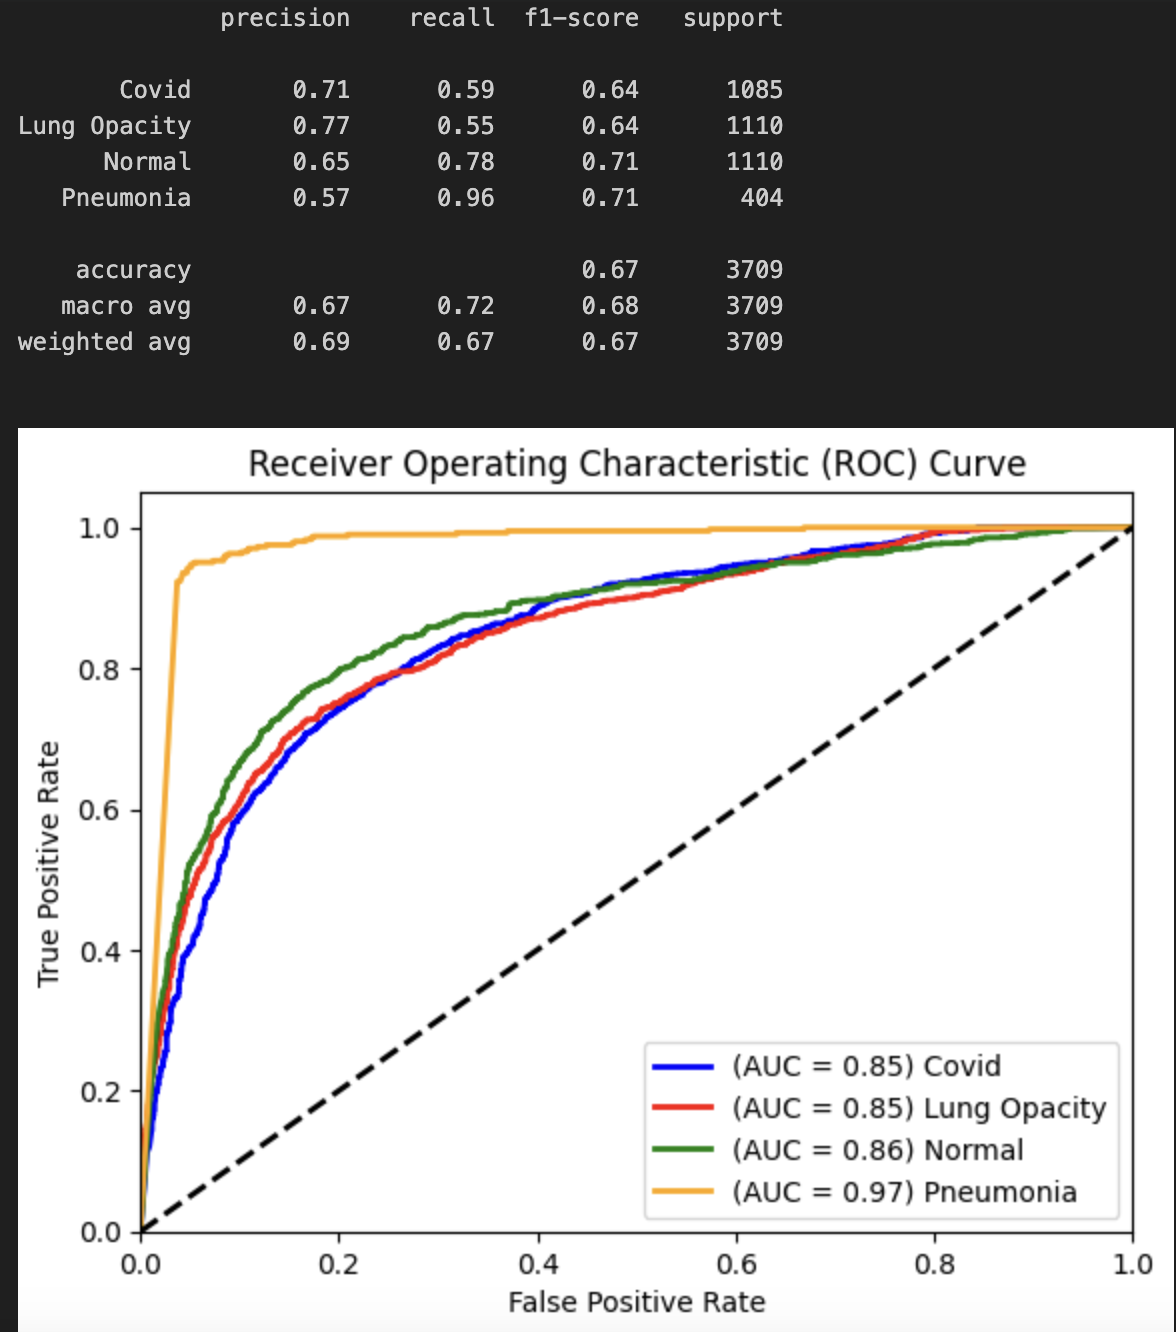